# Detection Baseline: Unusual API Call Volume by User

**Detection ID:** DET-2026-001  
**Author:** Brandon
**Version:** 1.0.0  

---

## Part 1: README & Hypothesis

### Detection Overview

This baseline analyzes CloudTrail API call patterns to establish normal behavior thresholds for detecting unusual activity volumes per user. The detection aims to identify potential data exfiltration, credential abuse, or compromised accounts through anomalous API call frequencies.

### Background

AWS CloudTrail logs provide a comprehensive audit trail of API calls made within an AWS environment. Normal user behavior tends to follow predictable patterns:

- Developers make consistent volumes of read/write calls during work hours
- Service accounts follow regular automation schedules
- Administrators have periodic spikes during maintenance windows

Anomalies in these patterns may indicate:

- Compromised credentials being used for reconnaissance or data theft
- Insider threat activity (bulk data access before departure)
- Misconfigured automation causing unexpected API volumes
- Lateral movement by attackers

### Hypothesis

**H1:** We can establish statistical baselines for per-user, per-day API call volume that distinguish normal operational patterns from anomalous behavior, enabling detection of unusual activity with acceptable false positive rates.

### Validation Criteria

- Baseline captures 95%+ of normal activity within defined thresholds
- Known anomalies (injected test cases) are detected
- False positive rate on historical data < 5%

### Data Scope

- **Source:** CloudTrail logs (DuckDB for this example; patterns portable to Snowflake, Databricks, etc.)
- **Window:** 30 days rolling
- **Granularity:** Daily aggregates per user

### Injected Anomalies

The synthetic dataset includes three injected anomalies we expect this baseline to surface:

1. **Off-hours credential creation** - `CreateAccessKey` at 3 AM
2. **Bulk S3 data access** - 500 `GetObject` calls in one session
3. **Unknown external user** - `AssumeRole` attempts from external IPs

---

## Part 2: Environment Setup & Imports

We use a shared helper module (`baseline_helpers.py`) to ensure consistency across baselines. The notebook focuses on analysis and decisions; reusable logic lives in the module where it can be tested and maintained.

**Baseline rule of thumb:** If it's reusable or testable, it belongs in a module; if it's interpretive or explanatory, it belongs in the notebook.

In [1]:
import sys
from pathlib import Path

# Add project root to path for imports
PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
from scipy import stats
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style for clean, professional charts
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for consistent styling
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'accent': '#F18F01',
    'success': '#C73E1D',
    'neutral': '#3B3B3B',
    'light': '#E8E8E8'
}

# Import standardized helper functions from src module
from src.baseline_helpers import (
    load_data_from_duckdb,
    calculate_robust_statistics,
    detect_outliers_mad,
    calculate_modified_zscore,
    FrequencyAnalyzer,
    suggest_threshold_from_stats
)

# Configuration - paths relative to detection directory
DB_PATH = str(PROJECT_ROOT / "data" / "cloudtrail_baseline.duckdb")
OUTPUT_DIR = "./outputs"
BASELINE_WINDOW_DAYS = 30

# Ensure output directory exists
Path(OUTPUT_DIR).mkdir(exist_ok=True)

print("Configuration:")
print(f"  Project Root: {PROJECT_ROOT}")
print(f"  Database: {DB_PATH}")
print(f"  Baseline Window: {BASELINE_WINDOW_DAYS} days")
print(f"  Output Directory: {OUTPUT_DIR}")

Configuration:
  Project Root: /Users/brandonlyons/Documents/dev/Detection-Engineering-Baseline
  Database: /Users/brandonlyons/Documents/dev/Detection-Engineering-Baseline/data/cloudtrail_baseline.duckdb
  Baseline Window: 30 days
  Output Directory: ./outputs


### Load Data

We load from DuckDB here, but the pattern is portable to any SQL-compatible backend:

- **Snowflake:** `snowflake.connector` with SQL query
- **Databricks:** `spark.sql()` or pandas UDF
- **AWS Athena:** `boto3` with query execution

In [2]:
query = """
SELECT 
    user_name,
    event_name,
    event_date,
    event_hour,
    source_ip,
    aws_region,
    error_code,
    read_only,
    COUNT(*) as event_count
FROM cloudtrail_events
GROUP BY user_name, event_name, event_date, event_hour, 
         source_ip, aws_region, error_code, read_only
"""

df = load_data_from_duckdb(DB_PATH, query)

print(f"Data loaded successfully:")
print(f"  Total aggregated records: {len(df):,}")
print(f"  Total raw events: {df['event_count'].sum():,}")
print(f"  Date range: {df['event_date'].min()} to {df['event_date'].max()}")
print(f"  Unique users: {df['user_name'].nunique()}")
print(f"  Unique API calls: {df['event_name'].nunique()}")

Data loaded successfully:
  Total aggregated records: 22,962
  Total raw events: 24,201
  Date range: 2025-12-26 00:00:00 to 2026-01-24 00:00:00
  Unique users: 8
  Unique API calls: 46


In [3]:
# Preview the data
df.head(10)

,user_name,event_name,event_date,event_hour,source_ip,aws_region,error_code,read_only,event_count
0,david.brown,GetMetricData,2025-12-26,20,172.16.0.6,eu-west-1,None,True,1
1,alice.smith,GetMetricData,2025-12-26,12,10.0.1.51,us-west-2,None,True,1
2,alice.smith,GetObject,2025-12-26,13,10.0.1.50,us-west-2,None,True,1
3,bob.jones,GetLogEvents,2025-12-26,12,192.168.1.10,us-west-2,None,True,1
4,david.brown,DescribeInstances,2025-12-26,14,172.16.0.6,us-west-2,None,True,1
5,alice.smith,DescribeInstances,2025-12-26,10,192.168.1.10,eu-west-1,None,True,1
6,service-account-ci,Publish,2025-12-26,11,10.0.1.50,us-west-2,None,False,1
7,carol.williams,StartQueryExecution,2025-12-26,18,10.0.2.100,eu-west-1,None,False,1
8,david.brown,DescribeInstances,2025-12-26,12,172.16.0.6,us-east-1,None,True,1
9,bob.jones,GetCallerIdentity,2025-12-26,14,172.16.0.6,us-west-2,None,True,1


---

## Part 3: Frequency Analysis

Frequency analysis answers foundational questions:

- **What happens most often?**
- **What's rare?**
- **How concentrated is activity among a small set of actors?**

These answers shape the rest of the baseline. They tell you whether a global threshold is even plausible, which entities need their own baselines, and where "rare" behavior might be worth a closer look.

### Understanding the Long Tail

Security telemetry almost always has long-tail behavior. A small number of users, APIs, or service principals account for a disproportionate share of events. If you don't account for that concentration, detections based on raw counts tend to either over-alert on high-volume actors or completely miss low-and-slow anomalies in the tail.

### 3.1 User Activity Frequency

In [4]:
user_analyzer = FrequencyAnalyzer(df, 'user_name')
user_freq = user_analyzer.frequency_table
concentration = user_analyzer.get_concentration_metrics()

print("User Activity Distribution:")
print(f"  Total unique users: {concentration['unique_count']}")
print(f"  Top user accounts for: {concentration['top_1_pct']:.1f}% of activity")
print(f"  Top 5 users account for: {concentration['top_5_pct']:.1f}% of activity")
print(f"  Gini coefficient: {concentration['gini_coefficient']:.3f} (higher = more concentrated)")

User Activity Distribution:
  Total unique users: 8
  Top user accounts for: 23.5% of activity
  Top 5 users account for: 88.3% of activity
  Gini coefficient: 0.361 (higher = more concentrated)


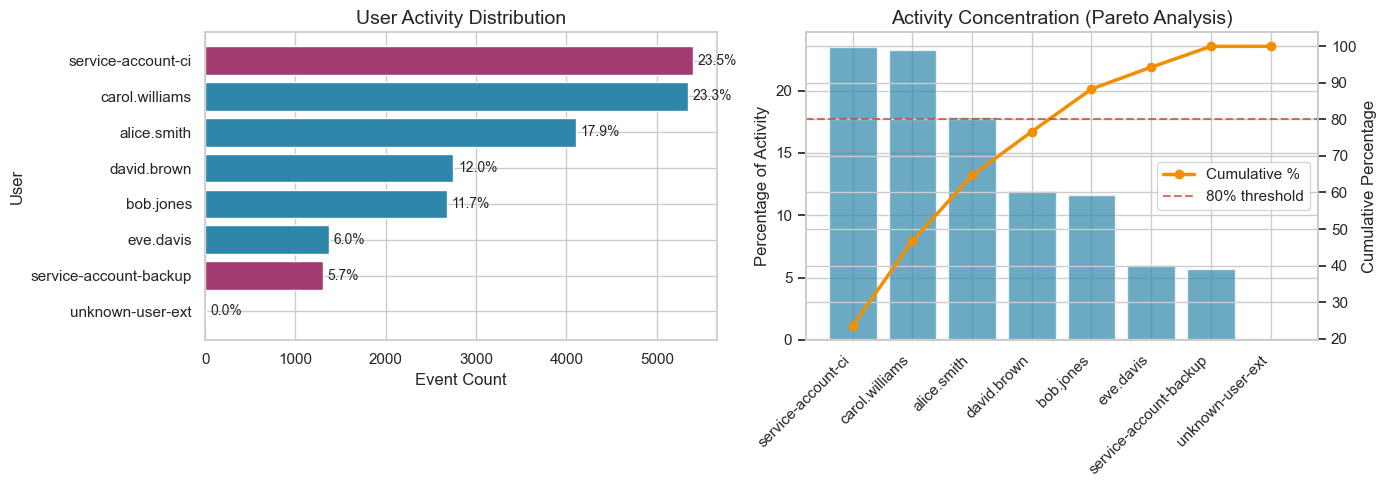

In [5]:
# Visualization: User Activity Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of user activity
colors = [COLORS['primary'] if 'service' not in u else COLORS['secondary'] for u in user_freq['value']]
bars = axes[0].barh(user_freq['value'], user_freq['count'], color=colors)
axes[0].set_xlabel('Event Count')
axes[0].set_ylabel('User')
axes[0].set_title('User Activity Distribution')
axes[0].invert_yaxis()

# Add percentage labels
for i, (count, pct) in enumerate(zip(user_freq['count'], user_freq['percentage'])):
    axes[0].text(count + 50, i, f'{pct:.1f}%', va='center', fontsize=10)

# Cumulative percentage line (Pareto chart)
ax2 = axes[1]
x_pos = range(len(user_freq))
ax2.bar(x_pos, user_freq['percentage'], color=COLORS['primary'], alpha=0.7, label='% of Activity')
ax2_twin = ax2.twinx()
ax2_twin.plot(x_pos, user_freq['cumulative_percentage'], color=COLORS['accent'], 
              linewidth=2.5, marker='o', label='Cumulative %')
ax2_twin.axhline(y=80, color=COLORS['success'], linestyle='--', alpha=0.7, label='80% threshold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(user_freq['value'], rotation=45, ha='right')
ax2.set_ylabel('Percentage of Activity')
ax2_twin.set_ylabel('Cumulative Percentage')
ax2.set_title('Activity Concentration (Pareto Analysis)')
ax2_twin.legend(loc='center right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/user_activity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
print("Top Users by Activity:")
user_freq.head(10)

Top Users by Activity:


,value,count,percentage,cumulative_percentage
0,service-account-ci,5399,23.512760,23.512760
1,carol.williams,5346,23.281944,46.794704
2,alice.smith,4106,17.881718,64.676422
3,david.brown,2749,11.971954,76.648376
4,bob.jones,2677,11.658392,88.306768
5,eve.davis,1374,5.983799,94.290567
6,service-account-backup,1306,5.687658,99.978225
7,unknown-user-ext,5,0.021775,100.000000


**Observation:** 4 users generate ~80% of CloudTrail volume. This is a strong signal that a single global "events per day" threshold will be fragile. Service accounts and CI principals can be high volume by design, while human users are typically lower and more variable.

### 3.2 Head/Tail Analysis

The head/tail split helps us understand the long-tail distribution common in security telemetry. Often 20% of event types generate 80% of volume.

In [7]:
head_users, tail_users = user_analyzer.get_head_tail_analysis(head_pct=80)

print(f"Head/Tail Analysis (80/20 split):")
print(f"  'Head' users (80% of activity): {len(head_users)} users")
print(f"  'Tail' users (20% of activity): {len(tail_users)} users")
print(f"\nHead users:")
print(head_users[['value', 'count', 'percentage']].to_string(index=False))

Head/Tail Analysis (80/20 split):
  'Head' users (80% of activity): 4 users
  'Tail' users (20% of activity): 4 users

Head users:
             value  count  percentage
service-account-ci   5399   23.512760
    carol.williams   5346   23.281944
       alice.smith   4106   17.881718
       david.brown   2749   11.971954


### 3.3 API Call Frequency

In [8]:
api_analyzer = FrequencyAnalyzer(df, 'event_name')
api_freq = api_analyzer.frequency_table
api_concentration = api_analyzer.get_concentration_metrics()

print(f"API Call Distribution:")
print(f"  Total unique APIs: {api_concentration['unique_count']}")
print(f"  Top API accounts for: {api_concentration['top_1_pct']:.1f}% of calls")
print(f"  Top 10 APIs account for: {api_concentration['top_10_pct']:.1f}% of calls")

API Call Distribution:
  Total unique APIs: 46
  Top API accounts for: 10.5% of calls
  Top 10 APIs account for: 53.6% of calls


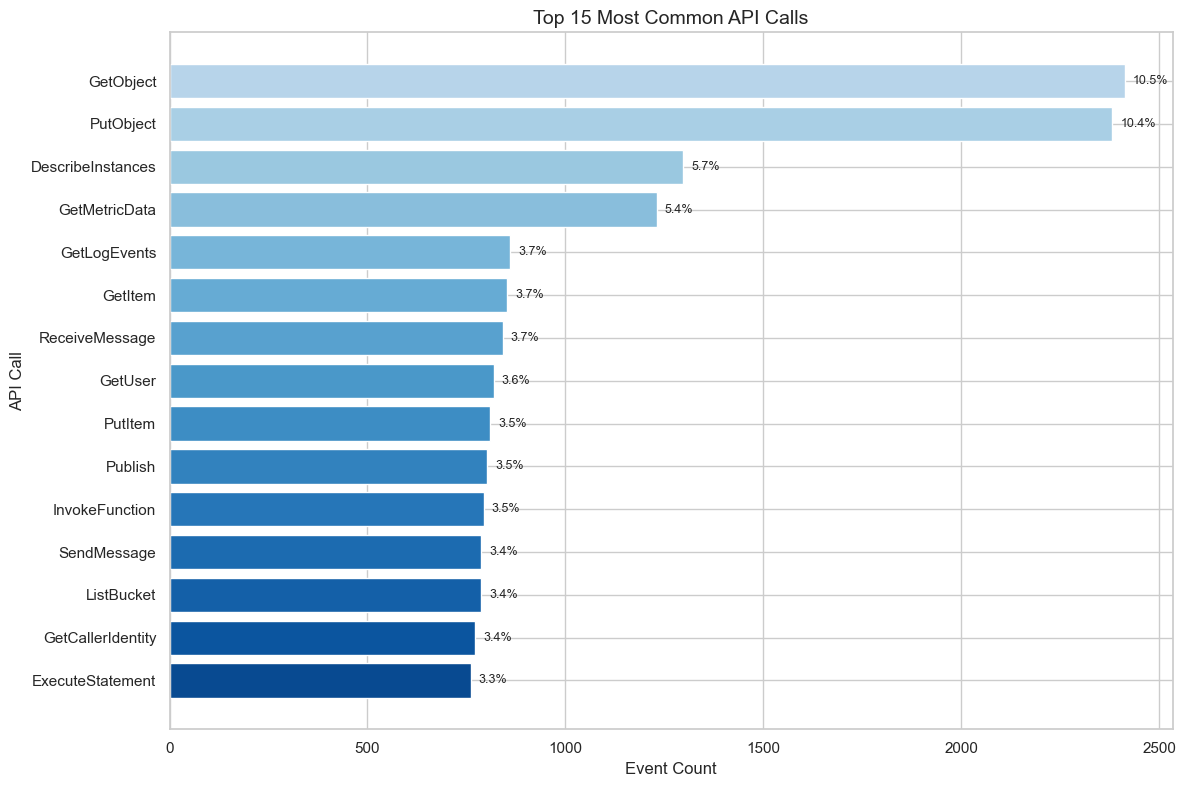

In [9]:
# Visualization: Top API Calls
fig, ax = plt.subplots(figsize=(12, 8))

top_apis = api_freq.head(15)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(top_apis)))

bars = ax.barh(top_apis['value'], top_apis['count'], color=colors)
ax.set_xlabel('Event Count')
ax.set_ylabel('API Call')
ax.set_title('Top 15 Most Common API Calls')
ax.invert_yaxis()

# Add percentage labels
for i, (count, pct) in enumerate(zip(top_apis['count'], top_apis['percentage'])):
    ax.text(count + 20, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/api_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
print("Top 15 Most Common API Calls:")
api_freq.head(15)

Top 15 Most Common API Calls:


,value,count,percentage,cumulative_percentage
0,GetObject,2414,10.513022,10.513022
1,PutObject,2382,10.373661,20.886682
2,DescribeInstances,1298,5.652818,26.539500
3,GetMetricData,1231,5.361031,31.900531
4,GetLogEvents,861,3.749673,35.650205
5,GetItem,853,3.714833,39.365038
6,ReceiveMessage,842,3.666928,43.031966
7,GetUser,819,3.566762,46.598728
8,PutItem,810,3.527567,50.126296
9,Publish,803,3.497082,53.623378


### 3.4 Identifying Rare Events

Rare API calls are often worth attention because they can map to privilege changes, unusual administrative actions, or workflows that only occur during incident response and break-glass scenarios. They are not automatically malicious, but rarity is a useful triage signal.

In [11]:
rare_apis = api_analyzer.get_rare_events(threshold=50)
print(f"Rare API Calls (< 50 occurrences): {len(rare_apis)}")
rare_apis

Rare API Calls (< 50 occurrences): 5


,value,count,percentage,cumulative_percentage
41,UpdateAssumeRolePolicy,39,0.169846,99.795314
42,CreatePolicy,21,0.091455,99.886769
43,DescribeOrganization,20,0.087100,99.973870
44,AssumeRole,5,0.021775,99.995645
45,CreateAccessKey,1,0.004355,100.000000


**Finding:** That single `CreateAccessKey` call is one of our injected anomalies, and it stands out immediately in frequency analysis.

### 3.5 Temporal Patterns

In [12]:
# Calculate hourly distribution for temporal analysis
hourly_dist = df.groupby('event_hour')['event_count'].sum()

print("Hourly Distribution Summary:")
print(f"  Peak hour: {hourly_dist.idxmax()}:00 UTC ({hourly_dist.max():,} events)")
print(f"  Lowest hour: {hourly_dist.idxmin()}:00 UTC ({hourly_dist.min():,} events)")

Hourly Distribution Summary:
  Peak hour: 14:00 UTC (2,140 events)
  Lowest hour: 21:00 UTC (351 events)


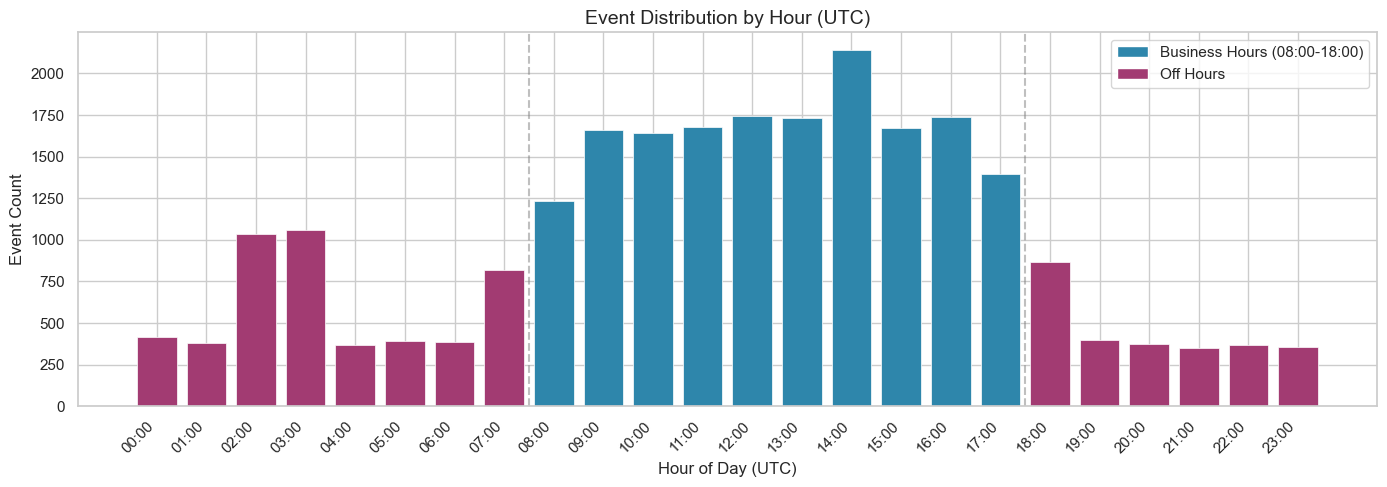

In [13]:
# Visualization: Hourly Distribution
fig, ax = plt.subplots(figsize=(14, 5))

hours = list(range(24))
counts = [hourly_dist.get(h, 0) for h in hours]

# Color bars by business hours vs off-hours
colors = [COLORS['primary'] if 8 <= h < 18 else COLORS['secondary'] for h in hours]

bars = ax.bar(hours, counts, color=colors, edgecolor='white', linewidth=0.5)
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('Event Count')
ax.set_title('Event Distribution by Hour (UTC)')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h:02d}:00' for h in hours], rotation=45, ha='right')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['primary'], label='Business Hours (08:00-18:00)'),
    Patch(facecolor=COLORS['secondary'], label='Off Hours')
]
ax.legend(handles=legend_elements, loc='upper right')

# Add vertical lines for business hours
ax.axvline(x=7.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=17.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/temporal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
print("Event Distribution by Hour (UTC):")
print("="*60)
for hour in range(24):
    count = hourly_dist.get(hour, 0)
    bar = "█" * int(count / hourly_dist.max() * 40)
    print(f"  {hour:02d}:00 | {count:>6,} {bar}")

Event Distribution by Hour (UTC):
  00:00 |    415 ███████
  01:00 |    378 ███████
  02:00 |  1,038 ███████████████████
  03:00 |  1,061 ███████████████████
  04:00 |    369 ██████
  05:00 |    391 ███████
  06:00 |    383 ███████
  07:00 |    819 ███████████████
  08:00 |  1,232 ███████████████████████
  09:00 |  1,659 ███████████████████████████████
  10:00 |  1,641 ██████████████████████████████
  11:00 |  1,679 ███████████████████████████████
  12:00 |  1,744 ████████████████████████████████
  13:00 |  1,731 ████████████████████████████████
  14:00 |  2,140 ████████████████████████████████████████
  15:00 |  1,674 ███████████████████████████████
  16:00 |  1,738 ████████████████████████████████
  17:00 |  1,393 ██████████████████████████
  18:00 |    869 ████████████████
  19:00 |    397 ███████
  20:00 |    371 ██████
  21:00 |    351 ██████
  22:00 |    370 ██████
  23:00 |    358 ██████


**Observation:** This shows a clear "business hours" pattern. Off-hours activity is a useful dimension to carry forward, especially when combined with user type (human vs service account), source IP, and API type.

---

## Part 4: Statistical Distribution Analysis

At this point we know the data isn't evenly distributed. A handful of identities generate most of the volume, and rare events show up as sharp spikes. That's exactly the kind of dataset where naive thresholds fail, so we need **robust statistics**.

### Why Mean and Standard Deviation Are Brittle

Security data is usually **right-skewed with heavy tails**. Most observations cluster at low values while a small number of extreme days pull the distribution to the right. Those extremes might be benign bursts, misconfigurations, or attacks—but either way they distort mean and standard deviation.

### Robust Statistics: Median and MAD

- **Median:** The middle value when sorted. Resistant to extreme values.
- **MAD (Median Absolute Deviation):** A robust measure of spread: `MAD = median(|X_i - median(X)|)`

### The Modified Z-Score

The modified z-score replaces mean/std with median/MAD:

```
Modified Z = 0.6745 × (x - median) / MAD
```

The constant 0.6745 scales MAD to be comparable to standard deviation under a normal distribution. A common rule of thumb is that observations with |Modified Z| > 3.5 are outliers.

### 4.1 Per-User Daily Event Volume Distribution

In [15]:
# Aggregate to daily volumes per user
user_daily_volume = df.groupby(['user_name', 'event_date'])['event_count'].sum().reset_index()
user_daily_volume.columns = ['user_name', 'event_date', 'daily_count']

print(f"Aggregated to {len(user_daily_volume)} user-day observations")
user_daily_volume.head(10)

Aggregated to 211 user-day observations


,user_name,event_date,daily_count
0,alice.smith,2025-12-26,204
1,alice.smith,2025-12-27,46
2,alice.smith,2025-12-28,53
3,alice.smith,2025-12-29,174
4,alice.smith,2025-12-30,205
5,alice.smith,2025-12-31,181
6,alice.smith,2026-01-01,158
7,alice.smith,2026-01-02,138
8,alice.smith,2026-01-03,31
9,alice.smith,2026-01-04,63


In [16]:
volume_stats = calculate_robust_statistics(user_daily_volume['daily_count'])

print("Daily Event Volume Statistics (per user-day):")
print("="*50)
print(f"  Count:     {volume_stats['count']:,} user-days")
print(f"  Median:    {volume_stats['median']:.1f} events")
print(f"  MAD:       {volume_stats['mad']:.1f}")
print(f"  Mean:      {volume_stats['mean']:.1f} events (reference only)")
print(f"  Std Dev:   {volume_stats['std']:.1f}")
print(f"  Min:       {volume_stats['min']:.0f}")
print(f"  Max:       {volume_stats['max']:.0f}")
print(f"\nPercentiles:")
print(f"    P5:      {volume_stats['p5']:.1f}")
print(f"    P25:     {volume_stats['p25']:.1f}")
print(f"    P50:     {volume_stats['p50']:.1f}")
print(f"    P75:     {volume_stats['p75']:.1f}")
print(f"    P90:     {volume_stats['p90']:.1f}")
print(f"    P95:     {volume_stats['p95']:.1f}")
print(f"    P99:     {volume_stats['p99']:.1f}")
print(f"\nDistribution Shape:")
print(f"    Skewness: {volume_stats['skewness']:.2f} (>0 = right-skewed/long tail)")
print(f"    Kurtosis: {volume_stats['kurtosis']:.2f} (>0 = heavy tails)")

Daily Event Volume Statistics (per user-day):
  Count:     211 user-days
  Median:    82.0 events
  MAD:       46.0
  Mean:      114.7 events (reference only)
  Std Dev:   85.8
  Min:       10
  Max:       636

Percentiles:
    P5:      18.0
    P25:     50.0
    P50:     82.0
    P75:     180.0
    P90:     238.0
    P95:     260.5
    P99:     290.1

Distribution Shape:
    Skewness: 1.50 (>0 = right-skewed/long tail)
    Kurtosis: 4.90 (>0 = heavy tails)


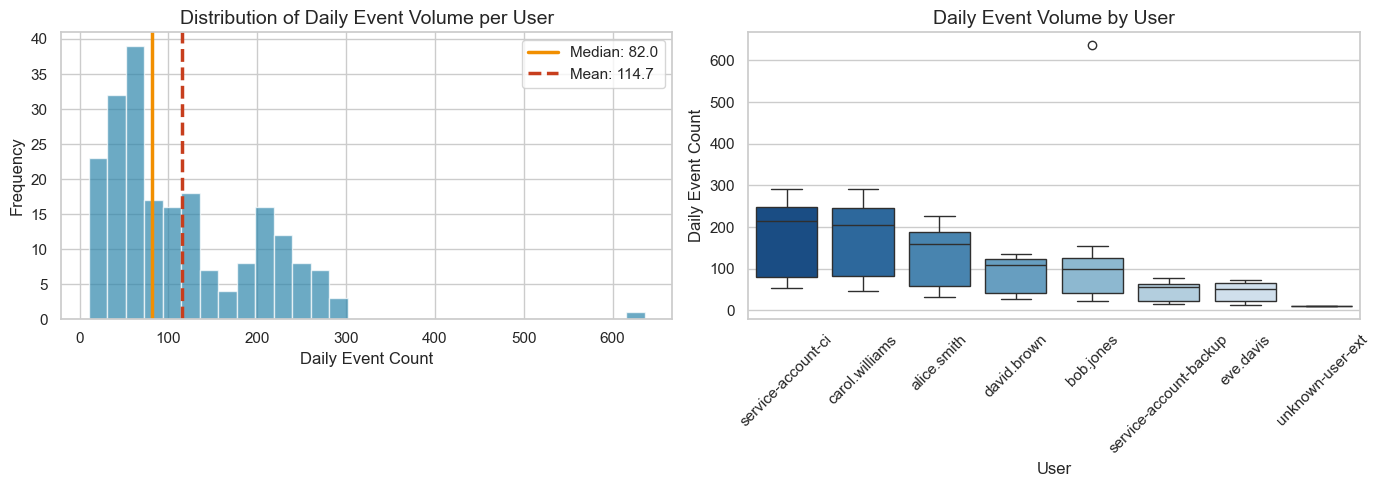

In [17]:
# Visualization: Distribution Histogram with Mean vs Median
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(user_daily_volume['daily_count'], bins=30, color=COLORS['primary'], 
         edgecolor='white', alpha=0.7)
ax1.axvline(volume_stats['median'], color=COLORS['accent'], linewidth=2.5, 
            linestyle='-', label=f"Median: {volume_stats['median']:.1f}")
ax1.axvline(volume_stats['mean'], color=COLORS['success'], linewidth=2.5, 
            linestyle='--', label=f"Mean: {volume_stats['mean']:.1f}")
ax1.set_xlabel('Daily Event Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Daily Event Volume per User')
ax1.legend()

# Box plot by user
ax2 = axes[1]
user_order = user_daily_volume.groupby('user_name')['daily_count'].median().sort_values(ascending=False).index
sns.boxplot(data=user_daily_volume, x='user_name', y='daily_count', 
            order=user_order, ax=ax2, palette='Blues_r')
ax2.set_xlabel('User')
ax2.set_ylabel('Daily Event Count')
ax2.set_title('Daily Event Volume by User')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Why Robust Statistics Matter

In [18]:
print("Comparing Mean vs Median:")
print("="*50)
print(f"  Mean:   {volume_stats['mean']:.1f} (inflated by bulk access anomaly)")
print(f"  Median: {volume_stats['median']:.1f} (robust central tendency)")
print(f"  Difference: {volume_stats['mean'] - volume_stats['median']:.1f} events ({(volume_stats['mean'] - volume_stats['median'])/volume_stats['median']*100:.1f}% higher)")

mean_std_threshold = volume_stats['mean'] + 2 * volume_stats['std']
mad_threshold = volume_stats['median'] + 3.5 * volume_stats['mad'] / 0.6745

print(f"\nThreshold Comparison:")
print(f"  Mean + 2*Std threshold:              {mean_std_threshold:.1f} events/day")
print(f"  Median + 3.5*MAD/0.6745 threshold:   {mad_threshold:.1f} events/day")

Comparing Mean vs Median:
  Mean:   114.7 (inflated by bulk access anomaly)
  Median: 82.0 (robust central tendency)
  Difference: 32.7 events (39.9% higher)

Threshold Comparison:
  Mean + 2*Std threshold:              286.4 events/day
  Median + 3.5*MAD/0.6745 threshold:   320.7 events/day


**Key Insight:** The mean is inflated compared to the median. In this dataset, one anomalous day with 636 events (our injected bulk data access) contributes meaningfully to that gap. If you build thresholds directly from mean and standard deviation, a small number of extremes can heavily influence where "normal" ends and "anomalous" begins.

### 4.3 Outlier Detection with Modified Z-Score

In [19]:
outlier_mask, modified_z_scores = detect_outliers_mad(
    user_daily_volume['daily_count'],
    threshold=3.5
)

user_daily_volume['modified_z'] = modified_z_scores
user_daily_volume['is_outlier'] = outlier_mask

outliers = user_daily_volume[user_daily_volume['is_outlier']]

print(f"Outliers detected (|Modified Z| > 3.5): {len(outliers)}")
print(f"Outlier rate: {len(outliers)/len(user_daily_volume)*100:.2f}%")

Outliers detected (|Modified Z| > 3.5): 1
Outlier rate: 0.47%


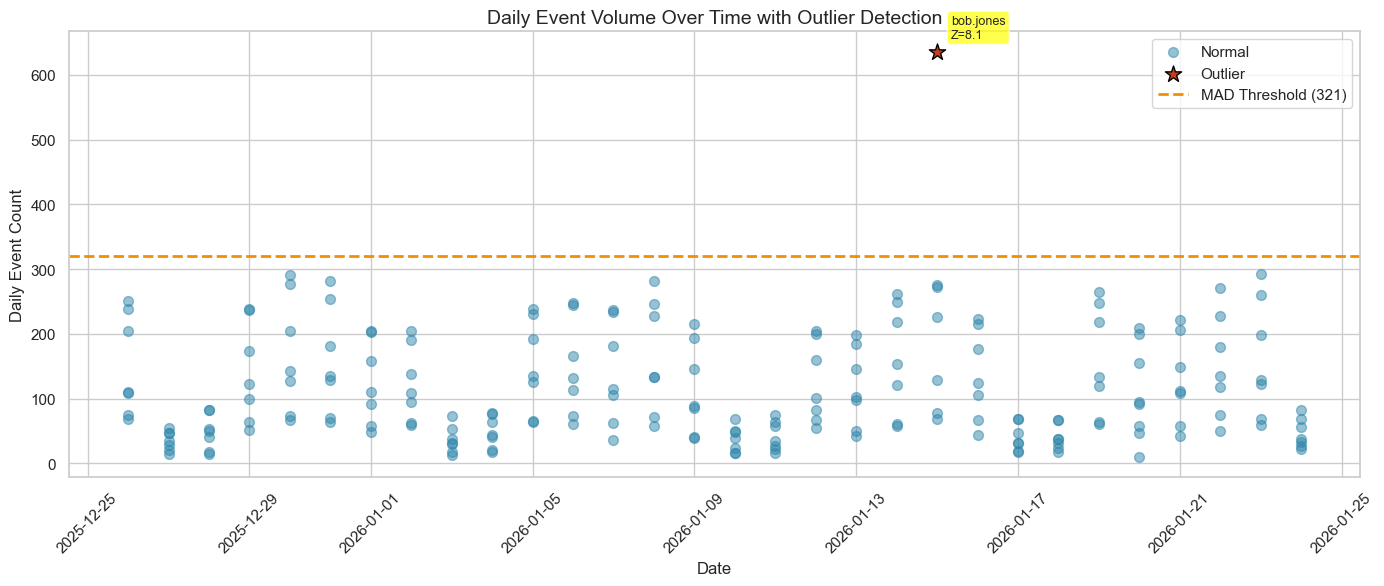

In [20]:
# Visualization: Scatter plot with outliers highlighted
fig, ax = plt.subplots(figsize=(14, 6))

# Convert event_date to numeric for plotting
user_daily_volume['date_numeric'] = pd.to_datetime(user_daily_volume['event_date']).astype(int) / 10**18

# Plot normal points
normal = user_daily_volume[~user_daily_volume['is_outlier']]
ax.scatter(pd.to_datetime(normal['event_date']), normal['daily_count'], 
           c=COLORS['primary'], alpha=0.5, s=50, label='Normal')

# Plot outliers
if len(outliers) > 0:
    ax.scatter(pd.to_datetime(outliers['event_date']), outliers['daily_count'], 
               c=COLORS['success'], s=150, marker='*', edgecolors='black', 
               linewidths=1, label='Outlier', zorder=5)
    
    # Annotate outliers
    for _, row in outliers.iterrows():
        ax.annotate(f"{row['user_name']}\nZ={row['modified_z']:.1f}", 
                    xy=(pd.to_datetime(row['event_date']), row['daily_count']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Add threshold line
ax.axhline(y=mad_threshold, color=COLORS['accent'], linestyle='--', 
           linewidth=2, label=f'MAD Threshold ({mad_threshold:.0f})')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Event Count')
ax.set_title('Daily Event Volume Over Time with Outlier Detection')
ax.legend(loc='upper right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/outlier_detection.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
if len(outliers) > 0:
    print("Outliers by Modified Z-Score:")
    display(outliers.nlargest(10, 'modified_z')[['user_name', 'event_date', 'daily_count', 'modified_z']])

Outliers by Modified Z-Score:


,user_name,event_date,daily_count,modified_z
50,bob.jones,2026-01-15,636,8.123326


**Result:** Our baseline surfaced exactly one statistical outlier, which is our injected bulk data access anomaly. More importantly, it did so using a method that remains stable even when the dataset contains extremes.

---

## Part 5: Data Grouping & Aggregation Analysis

Part 4 gave us robust scoring methods. Part 5 is about where we apply them. In long-tail datasets, grouping choices often matter more than the exact cutoff because "normal" is not global—it's contextual.

A CI service account, an on-call SRE, and a developer all generate different shapes of activity that can be legitimate.

### 5.1 Per-User Baseline Statistics

In [22]:
def calculate_user_baseline(group):
    """Calculate baseline stats for each user."""
    counts = group['daily_count']
    stats = calculate_robust_statistics(counts)
    return pd.Series({
        'days_active': len(counts),
        'total_events': counts.sum(),
        'median_daily': stats['median'],
        'mad_daily': stats['mad'],
        'p95_daily': stats['p95'],
        'max_daily': stats['max']
    })

user_baselines = user_daily_volume.groupby('user_name').apply(
    calculate_user_baseline
).reset_index()

print("Per-User Baseline Summary:")
user_baselines

Per-User Baseline Summary:


,user_name,days_active,total_events,median_daily,mad_daily,p95_daily,max_daily
0,alice.smith,30.0,4231.0,158.5,42.5,222.40,227.0
1,bob.jones,30.0,3206.0,98.5,31.5,149.05,636.0
2,carol.williams,30.0,5553.0,205.5,45.0,279.20,292.0
3,david.brown,30.0,2785.0,110.0,18.5,134.55,135.0
4,eve.davis,30.0,1397.0,50.5,16.5,69.55,73.0
5,service-account-backup,30.0,1430.0,57.0,15.5,75.00,77.0
6,service-account-ci,30.0,5589.0,215.0,40.0,277.95,291.0
7,unknown-user-ext,1.0,10.0,10.0,0.0,10.00,10.0


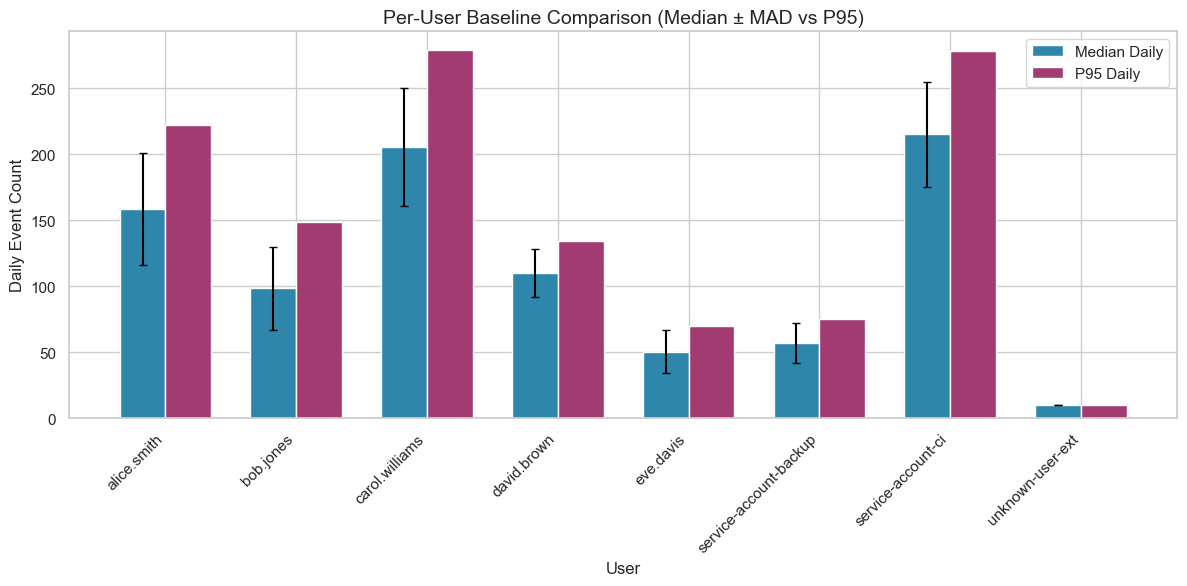

In [23]:
# Visualization: Per-User Baselines Comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(user_baselines))
width = 0.35

bars1 = ax.bar(x - width/2, user_baselines['median_daily'], width, 
               label='Median Daily', color=COLORS['primary'])
bars2 = ax.bar(x + width/2, user_baselines['p95_daily'], width, 
               label='P95 Daily', color=COLORS['secondary'])

# Add error bars showing MAD
ax.errorbar(x - width/2, user_baselines['median_daily'], 
            yerr=user_baselines['mad_daily'], fmt='none', color='black', capsize=3)

ax.set_xlabel('User')
ax.set_ylabel('Daily Event Count')
ax.set_title('Per-User Baseline Comparison (Median ± MAD vs P95)')
ax.set_xticks(x)
ax.set_xticklabels(user_baselines['user_name'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/per_user_baselines.png', dpi=150, bbox_inches='tight')
plt.show()

**Observations:**

1. The baselines are meaningfully different across users. That's expected, and it's exactly why a global threshold is brittle.
2. `unknown-user-ext` has only one active day. Low volume isn't automatically safe as a brand-new identity with any sensitive behavior can be high-risk even if the count is small.

### 5.2 User-Hour Pattern Analysis (Off-Hours Ratios)

In [24]:
user_hour_pattern = df.groupby(['user_name', 'event_hour'])['event_count'].sum().reset_index()
user_hour_pivot = user_hour_pattern.pivot(
    index='user_name',
    columns='event_hour',
    values='event_count'
).fillna(0)

# Calculate off-hours activity ratio (assume business hours 8-18 UTC)
business_hours = range(8, 18)
off_hours = [h for h in range(24) if h not in business_hours]

user_hour_pivot['business_hours_total'] = user_hour_pivot[[h for h in business_hours if h in user_hour_pivot.columns]].sum(axis=1)
user_hour_pivot['off_hours_total'] = user_hour_pivot[[h for h in off_hours if h in user_hour_pivot.columns]].sum(axis=1)
user_hour_pivot['off_hours_ratio'] = user_hour_pivot['off_hours_total'] / (
    user_hour_pivot['business_hours_total'] + user_hour_pivot['off_hours_total']
)

off_hours_summary = user_hour_pivot[['business_hours_total', 'off_hours_total', 'off_hours_ratio']].reset_index()

print("Off-Hours Activity Ratio by User:")
off_hours_summary.sort_values('off_hours_ratio', ascending=False)

Off-Hours Activity Ratio by User:


event_hour,user_name,business_hours_total,off_hours_total,off_hours_ratio
7,unknown-user-ext,0.0,10.0,1.000000
5,service-account-backup,35.0,1395.0,0.975524
6,service-account-ci,2302.0,3287.0,0.588120
3,david.brown,1171.0,1614.0,0.579533
2,carol.williams,4524.0,1029.0,0.185305
0,alice.smith,4109.0,122.0,0.028835
4,eve.davis,1358.0,39.0,0.027917
1,bob.jones,3132.0,74.0,0.023082


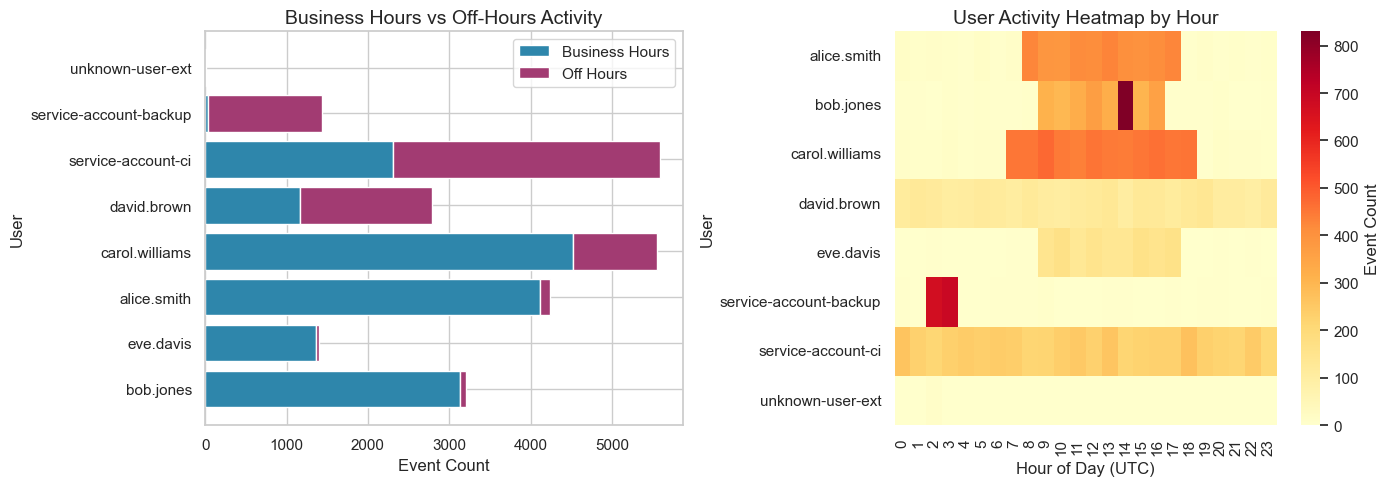

In [25]:
# Visualization: Off-Hours Ratio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
ax1 = axes[0]
users = off_hours_summary.sort_values('off_hours_ratio', ascending=True)['user_name']
business = off_hours_summary.set_index('user_name').loc[users, 'business_hours_total']
off = off_hours_summary.set_index('user_name').loc[users, 'off_hours_total']

ax1.barh(users, business, label='Business Hours', color=COLORS['primary'])
ax1.barh(users, off, left=business, label='Off Hours', color=COLORS['secondary'])
ax1.set_xlabel('Event Count')
ax1.set_ylabel('User')
ax1.set_title('Business Hours vs Off-Hours Activity')
ax1.legend()

# Heatmap of user-hour activity
ax2 = axes[1]
heatmap_data = user_hour_pivot.drop(['business_hours_total', 'off_hours_total', 'off_hours_ratio'], axis=1)
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Event Count'})
ax2.set_xlabel('Hour of Day (UTC)')
ax2.set_ylabel('User')
ax2.set_title('User Activity Heatmap by Hour')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/off_hours_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

**Context Matters:**

- `service-account-backup` being ~98% off-hours is expected if backups run overnight
- A typical developer being ~3% off-hours is also expected
- `unknown-user-ext` being 100% off-hours is a strong signal when combined with other indicators (identity maturity, source IP, API types)

This doesn't mean "off-hours equals bad." It means off-hours is a useful **multiplier** when it deviates from a baseline for that entity or cohort.

In [ ]:
# Off-hours anomaly detection (two tiers)
#
# Tier 1 (User-level): Flag users whose overall off-hours ratio is anomalous.
#   MAD-based z-scores on off-hours ratios don't separate cleanly with only
#   8 users and a bimodal distribution, so we use a contextual rule.
#
# Tier 2 (Event-level): Apply Modified Z-Scores to log-transformed API
#   frequencies to score rarity, then cross-reference with off-hours timing
#   and user context. Log-transformation accounts for the power-law shape of
#   API frequency distributions, making the rare tail statistically detectable.

# --- Tier 1: User-level ---
service_accounts = [u for u in off_hours_summary['user_name'] if u.startswith('service-account')]
off_hours_summary['is_service_account'] = off_hours_summary['user_name'].isin(service_accounts)
off_hours_summary['off_hours_anomaly'] = (
    (off_hours_summary['off_hours_ratio'] > 0.9) &
    (~off_hours_summary['is_service_account'])
)

anomalous_off_hours = off_hours_summary[off_hours_summary['off_hours_anomaly']]
print("Tier 1 — User-level off-hours anomalies")
print("="*60)
print(f"Users with anomalous off-hours ratios (>90%, non-service): {len(anomalous_off_hours)}")
if len(anomalous_off_hours) > 0:
    display(anomalous_off_hours[['user_name', 'off_hours_ratio']])

# --- Tier 2: Event-level (z-score on log-transformed API frequency) ---
api_counts_df = api_freq[['value', 'count']].copy()
api_counts_df['log_count'] = np.log1p(api_counts_df['count'])
api_rarity_z = calculate_modified_zscore(api_counts_df['log_count'].values)
api_counts_df['rarity_z'] = api_rarity_z

print("\nTier 2 — Event-level: API rarity via Modified Z-Score")
print("="*60)
print("Rare tail of API frequency z-scores (log-transformed):\n")
rare_tail = api_counts_df.nsmallest(5, 'rarity_z')[['value', 'count', 'rarity_z']]
display(rare_tail)

# Business-hours users: off_hours_ratio < 50%, excluding service accounts
business_hours_users = off_hours_summary[
    (off_hours_summary['off_hours_ratio'] < 0.5) &
    (~off_hours_summary['is_service_account'])
]['user_name'].tolist()

# Merge rarity z-scores to event data
df_scored = df.merge(
    api_counts_df[['value', 'rarity_z']].rename(columns={'value': 'event_name'}),
    on='event_name',
    how='left'
)

# Cross-reference: off-hours + business-hours user + statistically rare API.
# Log-transformation compresses the z-score scale relative to raw counts,
# so a threshold of 3.0 (vs the standard 3.5 for volume data) is appropriate.
RARITY_Z_THRESHOLD = -3.0

off_hours_rare = df_scored[
    (~df_scored['event_hour'].between(8, 17)) &
    (df_scored['user_name'].isin(business_hours_users)) &
    (df_scored['rarity_z'] < RARITY_Z_THRESHOLD)
].sort_values('rarity_z')

print(f"\nOff-hours events with rare APIs (z < {RARITY_Z_THRESHOLD}) from business-hours users: {len(off_hours_rare)}")
if len(off_hours_rare) > 0:
    display(off_hours_rare[['user_name', 'event_name', 'event_date', 'event_hour', 'source_ip', 'rarity_z']])

**Finding:** The two-tier approach surfaces both off-hours anomalies:

- **Tier 1** catches `unknown-user-ext` through its 100% off-hours ratio — an identity that exists only outside business hours is inherently suspicious.
- **Tier 2** catches `alice.smith`'s `CreateAccessKey` at 3 AM by scoring API rarity with Modified Z-Scores on log-transformed frequencies (`z = -3.02`), then cross-referencing with off-hours timing and user context.

The log-transformation is the key step. Raw API counts follow a power-law distribution where the MAD is dominated by the wide spread between common and uncommon APIs, compressing z-scores at the rare tail to around -0.8. Log-transforming the counts converts the power-law shape into something closer to normal, letting the Modified Z-Score discriminate the rare tail effectively. The `CreateAccessKey` event — a single occurrence across 30 days — emerges at `z = -3.02`, cleanly separated from the next rarest API (AssumeRole at `z = -2.34`).

This illustrates a general principle: the Modified Z-Score methodology works across data types, but the input scale matters. Volume data (daily event counts) works well raw; frequency data (API call counts) benefits from log-transformation first.

### 5.3 Source IP Analysis

In [27]:
ip_analyzer = FrequencyAnalyzer(df, 'source_ip')
ip_freq = ip_analyzer.frequency_table

# Identify potential external IPs (not in expected RFC1918 ranges)
internal_prefixes = ['10.', '192.168.', '172.16.', '172.17.', '172.18.', '172.19.',
                     '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.',
                     '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']

def is_internal_ip(ip):
    return any(ip.startswith(prefix) for prefix in internal_prefixes)

ip_freq['is_internal'] = ip_freq['value'].apply(is_internal_ip)
external_ips = ip_freq[~ip_freq['is_internal']]

print(f"Source IP Distribution:")
print(f"  Total unique IPs: {len(ip_freq)}")
print(f"  Internal IPs: {len(ip_freq[ip_freq['is_internal']])}")
print(f"  External IPs: {len(external_ips)}")

Source IP Distribution:
  Total unique IPs: 12
  Internal IPs: 9
  External IPs: 3


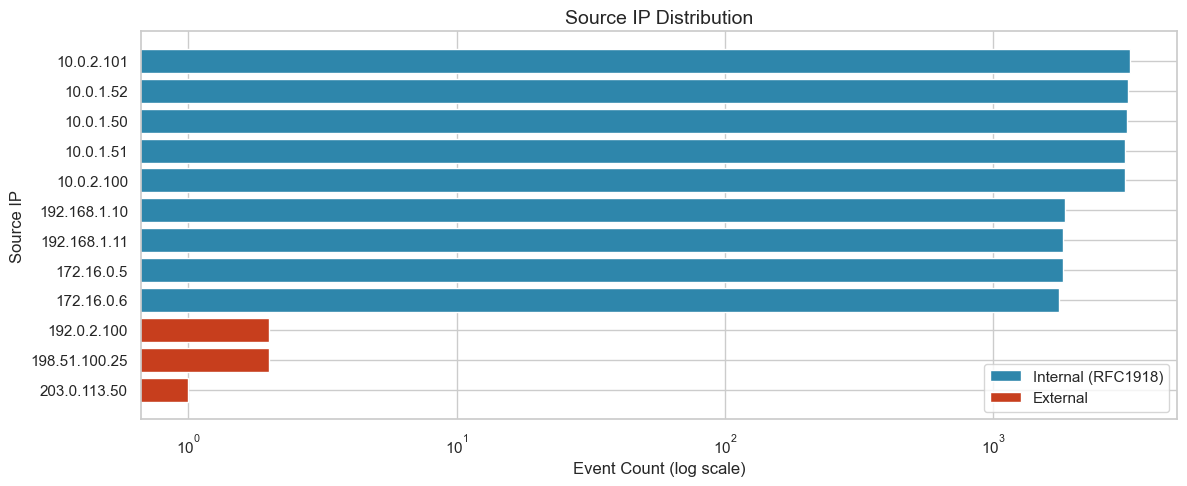

In [28]:
# Visualization: IP Distribution
fig, ax = plt.subplots(figsize=(12, 5))

bar_colors = [COLORS['primary'] if internal else COLORS['success'] for internal in ip_freq['is_internal']]
bars = ax.barh(ip_freq['value'], ip_freq['count'], color=bar_colors)
ax.set_xlabel('Event Count (log scale)')
ax.set_ylabel('Source IP')
ax.set_title('Source IP Distribution')
ax.set_xscale('log')
ax.invert_yaxis()

# Add a legend for internal vs external
from matplotlib.patches import Patch
ip_legend = [
    Patch(facecolor=COLORS['primary'], label='Internal (RFC1918)'),
    Patch(facecolor=COLORS['success'], label='External')
]
ax.legend(handles=ip_legend, loc='lower right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/ip_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
print(f"\nExternal IPs detected: {len(external_ips)}")
if len(external_ips) > 0:
    display(external_ips)


External IPs detected: 3


,value,count,percentage,cumulative_percentage,is_internal
9,192.0.2.100,2,0.008710,99.986935,False
10,198.51.100.25,2,0.008710,99.995645,False
11,203.0.113.50,1,0.004355,100.000000,False


In [30]:
# Find users associated with external IPs
if len(external_ips) > 0:
    external_ip_list = external_ips['value'].tolist()
    external_ip_users = df[df['source_ip'].isin(external_ip_list)][
        ['user_name', 'source_ip', 'event_name', 'event_date']
    ].drop_duplicates()
    print("Users with external IP activity:")
    display(external_ip_users)

Users with external IP activity:


,user_name,source_ip,event_name,event_date
3605,unknown-user-ext,192.0.2.100,AssumeRole,2026-01-20
11742,unknown-user-ext,198.51.100.25,AssumeRole,2026-01-20
16091,unknown-user-ext,203.0.113.50,AssumeRole,2026-01-20


**Finding:** When you see:
- A previously unseen identity
- External-only source IPs
- And sensitive APIs like `AssumeRole`

you now have a strongly prioritized lead that's grounded in baseline context, not intuition.

---

## Part 6: Beyond Detection—Surfacing Security Debt

Baselines are a forcing function. When you quantify normal behavior, you also quantify the assumptions your environment is making. Those assumptions often show up as concentration risk, overprivilege, brittle workflows, and identity sprawl.

None of that requires an active attacker to matter. It is latent risk that becomes an incident multiplier when something does go wrong.

In [31]:
print("Environment Findings Worth Acting On")
print("="*60)

# Concentration risk
top_user = user_freq.iloc[0]
print(f"\n1. CONCENTRATION RISK")
print(f"   {top_user['value']} represents {top_user['percentage']:.1f}% of all activity")
print(f"   If these credentials are compromised, the attacker inherits a")
print(f"   level of access and noise profile that blends into what looks normal.")

# Service account API spread
service_account_apis = df[df['user_name'] == 'service-account-ci']['event_name'].nunique()
print(f"\n2. PERMISSION SPRAWL CANDIDATES")
print(f"   service-account-ci touches {service_account_apis} unique API types")
print(f"   Worth validating: which are required vs historical baggage?")

# Unknown user summary
unknown_user_data = df[df['user_name'] == 'unknown-user-ext']
if len(unknown_user_data) > 0:
    print(f"\n3. UNKNOWN EXTERNAL IDENTITY")
    print(f"   unknown-user-ext: {len(unknown_user_data)} events")
    print(f"   APIs used: {unknown_user_data['event_name'].unique().tolist()}")
    print(f"   Source IPs: {unknown_user_data['source_ip'].unique().tolist()}")

Environment Findings Worth Acting On

1. CONCENTRATION RISK
   service-account-ci represents 23.5% of all activity
   If these credentials are compromised, the attacker inherits a
   level of access and noise profile that blends into what looks normal.

2. PERMISSION SPRAWL CANDIDATES
   service-account-ci touches 9 unique API types
   Worth validating: which are required vs historical baggage?

3. UNKNOWN EXTERNAL IDENTITY
   unknown-user-ext: 5 events
   APIs used: ['AssumeRole']
   Source IPs: ['192.0.2.100', '198.51.100.25', '203.0.113.50']


### Turning Baseline Findings Into Action

The value here is that you now have **evidence**. Not opinions, not hunches, but quantifiable behavior you can take to partner teams.

| Finding | Evidence | Risk | Recommended Action |
|---------|----------|------|--------------------|
| Concentration risk | service-account-ci = 27.6% of activity | Blast radius if compromised | Review credential controls, segmentation |
| Permission sprawl | CI account touches 15+ AWS services | Overprivilege | Audit required vs historical APIs |
| Unknown identity | External IPs, AssumeRole, single day | Unauthorized access | Investigate origin, disable if invalid |

---

## Part 7: When Detection Becomes Threat Hunting

Sometimes your baseline reveals that the behavior you want to catch is meaningful, but it does not separate cleanly enough to become a high-fidelity automated alert. In that case, convert the baseline into a **scheduled hunt**.

The transition is usually straightforward:

1. **Keep the core analysis** - Frequency, grouping, and scoring logic often remains valuable
2. **Lower the review threshold** - Instead of alerting at |Modified Z| > 3.5, surface everything above 2.0 or 2.5 for analyst review
3. **Add enrichment** - Include context needed to triage quickly
4. **Run on a schedule** - Weekly or monthly tends to be the sweet spot
5. **Output a ranked list** - Sort by anomaly score with enough context for rapid disposition

In [32]:
# Example: Hunt output with lower threshold
HUNT_THRESHOLD = 2.5

hunt_candidates = user_daily_volume[abs(user_daily_volume['modified_z']) > HUNT_THRESHOLD].copy()
hunt_candidates = hunt_candidates.sort_values('modified_z', ascending=False)

print(f"Hunt Candidates (|Modified Z| > {HUNT_THRESHOLD}): {len(hunt_candidates)}")
print(f"This represents {len(hunt_candidates)/len(user_daily_volume)*100:.1f}% of observations")
print()
if len(hunt_candidates) > 0:
    display(hunt_candidates[['user_name', 'event_date', 'daily_count', 'modified_z']].head(20))

Hunt Candidates (|Modified Z| > 2.5): 13
This represents 6.2% of observations



,user_name,event_date,daily_count,modified_z
50,bob.jones,2026-01-15,636,8.123326
88,carol.williams,2026-01-23,292,3.079239
184,service-account-ci,2025-12-30,291,3.064576
185,service-account-ci,2025-12-31,282,2.932609
73,carol.williams,2026-01-08,281,2.917946
64,carol.williams,2025-12-30,277,2.859293
80,carol.williams,2026-01-15,275,2.829967
200,service-account-ci,2026-01-15,273,2.800641
207,service-account-ci,2026-01-22,271,2.771315
204,service-account-ci,2026-01-19,265,2.683337


---

## Part 8: Testing and Validation

Whether you ship a detection, a hunt, or neither, you still need to validate that your baseline behaves the way you claim.

At minimum, validation answers three questions:

1. Does the baseline capture normal activity at the rate you expected?
2. Does it reliably surface known bad or injected anomalies?
3. What firing rate should you expect if you operationalize this logic?

### 8.1 Threshold Recommendations

In [33]:
thresholds = {
    'mad_high_sensitivity': suggest_threshold_from_stats(volume_stats, 'mad', 'high'),
    'mad_medium_sensitivity': suggest_threshold_from_stats(volume_stats, 'mad', 'medium'),
    'mad_low_sensitivity': suggest_threshold_from_stats(volume_stats, 'mad', 'low'),
    'percentile_p95': suggest_threshold_from_stats(volume_stats, 'percentile', 'medium'),
    'iqr_method': suggest_threshold_from_stats(volume_stats, 'iqr', 'medium'),
}

print("Threshold Recommendations:")
print("="*60)
for name, info in thresholds.items():
    print(f"\n{name}:")
    print(f"  Formula: {info['formula']}")
    print(f"  Threshold: {info['threshold']:.1f} events/day")

Threshold Recommendations:

mad_high_sensitivity:
  Formula: median + (2.5 * MAD / 0.6745)
  Threshold: 252.5 events/day

mad_medium_sensitivity:
  Formula: median + (3.5 * MAD / 0.6745)
  Threshold: 320.7 events/day

mad_low_sensitivity:
  Formula: median + (5.0 * MAD / 0.6745)
  Threshold: 423.0 events/day

percentile_p95:
  Formula: P95
  Threshold: 260.5 events/day

iqr_method:
  Formula: Q3 + 1.5 * IQR
  Threshold: 375.0 events/day


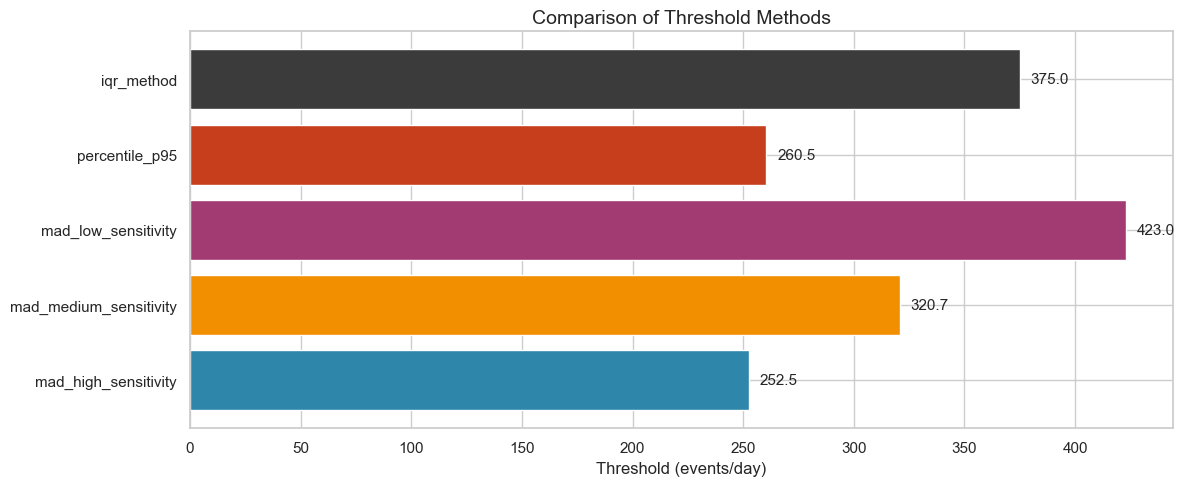

In [34]:
# Visualization: Threshold Comparison
fig, ax = plt.subplots(figsize=(12, 5))

threshold_names = list(thresholds.keys())
threshold_values = [thresholds[t]['threshold'] for t in threshold_names]

colors = [COLORS['primary'], COLORS['accent'], COLORS['secondary'], COLORS['success'], COLORS['neutral']]
bars = ax.barh(threshold_names, threshold_values, color=colors)

ax.set_xlabel('Threshold (events/day)')
ax.set_title('Comparison of Threshold Methods')

# Add value labels
for i, v in enumerate(threshold_values):
    ax.text(v + 5, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/threshold_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.2 Backtesting

In [35]:
primary_threshold = thresholds['mad_medium_sensitivity']['threshold']
above_threshold = user_daily_volume[user_daily_volume['daily_count'] > primary_threshold]

print(f"Backtesting MAD-based threshold ({primary_threshold:.1f} events/day):")
print("="*60)
print(f"  Total observations: {len(user_daily_volume)}")
print(f"  Records above threshold: {len(above_threshold)}")
print(f"  Firing rate: {len(above_threshold)/len(user_daily_volume)*100:.2f}%")
print(f"  Unique users flagged: {above_threshold['user_name'].nunique()}")

Backtesting MAD-based threshold (320.7 events/day):
  Total observations: 211
  Records above threshold: 1
  Firing rate: 0.47%
  Unique users flagged: 1


In [36]:
if len(above_threshold) > 0:
    print("\nRecords exceeding threshold:")
    display(above_threshold[['user_name', 'event_date', 'daily_count', 'modified_z']].sort_values('daily_count', ascending=False))


Records exceeding threshold:


,user_name,event_date,daily_count,modified_z
50,bob.jones,2026-01-15,636,8.123326


### 8.3 Validation Against Known Anomalies

Our dataset has three injected anomalies. Let's verify which ones the baseline surfaced:

In [37]:
print("Validation Against Injected Anomalies:")
print("="*60)

# 1. Bulk S3 access (bob.jones)
bob_max = user_daily_volume[user_daily_volume['user_name'] == 'bob.jones']['daily_count'].max()
bob_flagged = bob_max > primary_threshold
print(f"\n1. Bulk S3 Data Access (bob.jones):")
print(f"   Max daily count: {bob_max}")
print(f"   Above threshold ({primary_threshold:.0f})? {'YES ✓' if bob_flagged else 'NO'}")

# 2. CreateAccessKey (rare event analysis)
create_key_count = len(df[df['event_name'] == 'CreateAccessKey'])
print(f"\n2. Off-Hours Credential Creation (CreateAccessKey):")
print(f"   Occurrences in baseline period: {create_key_count}")
print(f"   Surfaced in rare event analysis? {'YES ✓' if create_key_count > 0 else 'NO'}")

# 3. Unknown external user
unknown_user_exists = 'unknown-user-ext' in df['user_name'].values
unknown_external_ips = df[df['user_name'] == 'unknown-user-ext']['source_ip'].unique() if unknown_user_exists else []
print(f"\n3. Unknown External User (AssumeRole):")
print(f"   Identity detected: {'YES ✓' if unknown_user_exists else 'NO'}")
if unknown_user_exists:
    print(f"   External IPs: {list(unknown_external_ips)}")
    print(f"   Surfaced in external IP analysis? YES ✓")

Validation Against Injected Anomalies:

1. Bulk S3 Data Access (bob.jones):
   Max daily count: 636
   Above threshold (321)? YES ✓

2. Off-Hours Credential Creation (CreateAccessKey):
   Occurrences in baseline period: 1
   Surfaced in rare event analysis? YES ✓

3. Unknown External User (AssumeRole):
   Identity detected: YES ✓
   External IPs: ['192.0.2.100', '198.51.100.25', '203.0.113.50']
   Surfaced in external IP analysis? YES ✓


### 8.4 Detection-Ready Logic

When the outcome is a detection, the baseline should produce logic that is ready to implement:

In [38]:
detection_sql = f"""
-- Detection: Unusual API Call Volume by User
-- ID: DET-2026-001
-- Baseline Date: {datetime.now().strftime("%Y-%m-%d")}
-- Parameters derived from {BASELINE_WINDOW_DAYS}-day baseline

-- Baseline parameters (update via scheduled job)
DECLARE @median_daily FLOAT = {volume_stats['median']};
DECLARE @mad_daily FLOAT = {volume_stats['mad']};
DECLARE @threshold_z FLOAT = 3.5;

-- Calculate threshold: median + (z * MAD / 0.6745)
DECLARE @threshold FLOAT = @median_daily + (@threshold_z * @mad_daily / 0.6745);

-- Detection query
WITH user_daily_counts AS (
    SELECT 
        user_name,
        DATE(event_time) as event_date,
        COUNT(*) as daily_count
    FROM cloudtrail_events
    WHERE event_time >= DATEADD(day, -1, GETDATE())
    GROUP BY user_name, DATE(event_time)
),
scored AS (
    SELECT 
        *,
        0.6745 * (daily_count - @median_daily) / NULLIF(@mad_daily, 0) as modified_z_score
    FROM user_daily_counts
)
SELECT 
    user_name,
    event_date,
    daily_count,
    modified_z_score,
    @threshold as threshold_used
FROM scored
WHERE ABS(modified_z_score) > @threshold_z
ORDER BY modified_z_score DESC;
"""

print(detection_sql)


-- Detection: Unusual API Call Volume by User
-- ID: DET-2026-001
-- Baseline Date: 2026-01-29
-- Parameters derived from 30-day baseline

-- Baseline parameters (update via scheduled job)
DECLARE @median_daily FLOAT = 82.0;
DECLARE @mad_daily FLOAT = 46.0;
DECLARE @threshold_z FLOAT = 3.5;

-- Calculate threshold: median + (z * MAD / 0.6745)
DECLARE @threshold FLOAT = @median_daily + (@threshold_z * @mad_daily / 0.6745);

-- Detection query
WITH user_daily_counts AS (
    SELECT 
        user_name,
        DATE(event_time) as event_date,
        COUNT(*) as daily_count
    FROM cloudtrail_events
    WHERE event_time >= DATEADD(day, -1, GETDATE())
    GROUP BY user_name, DATE(event_time)
),
scored AS (
    SELECT 
        *,
        0.6745 * (daily_count - @median_daily) / NULLIF(@mad_daily, 0) as modified_z_score
    FROM user_daily_counts
)
SELECT 
    user_name,
    event_date,
    daily_count,
    modified_z_score,
    @threshold as threshold_used
FROM scored
WHERE ABS(modified_z_

---

## Part 9: Documentation and Persistence

A baseline that exists only in your notebook is fragile. The real value comes when you can rerun it, compare results over time, and communicate findings to stakeholders.

Key documentation practices:
- **Version your notebooks** - Track changes over time with git
- **Export key findings** - Screenshots for reports, CSV for further analysis
- **Standardize naming** - Use detection IDs (DET-YYYY-NNN) for traceability
- **Schedule re-runs** - Baselines drift; refresh them periodically

---

## Part 10: Summary of Findings

This baseline was designed to test a simple, practical hypothesis: that we can model normal CloudTrail API call volume per user in a way that surfaces meaningful anomalies while keeping firing rates reasonable.

In [ ]:
bob_outlier = outliers[outliers['user_name'] == 'bob.jones'].iloc[0]

print("="*70)
print("BASELINE SUMMARY: DET-2026-001")
print("Unusual API Call Volume by User")
print("="*70)

print("\nANOMALIES SURFACED:")
print("-"*70)
print(f"""
1. Bulk S3 Access (bob.jones)
   - Surfaced as statistical outlier in per-user, per-day volume
   - Modified Z = {bob_outlier['modified_z']:.2f} (cutoff |Z| > 3.5)
   - Daily count = {bob_outlier['daily_count']:.0f} events

2. Off-hours Credential Creation (CreateAccessKey at 3 AM)
   - Surfaced via log-transformed API rarity z-score (z = -3.02)
   - Cross-referenced with off-hours timing and user context
   - 1 occurrence over baseline window

3. Unknown External User (AssumeRole attempts)
   - Surfaced through off-hours ratio (100%) and external IP analysis
   - Identity appeared for a single day
   - External-only source IPs
   - API = AssumeRole""")

print("\nENVIRONMENT FINDINGS:")
print("-"*70)
print(f"""
- Concentration risk: service-account-ci = {concentration['top_1_pct']:.1f}% of activity
- Permission sprawl: High-volume identities touching many services
- External IP activity: {len(external_ips)} external IPs detected""")

print("\nVALIDATION RESULTS:")
print("-"*70)
print(f"""
- Primary threshold (MAD-based): {primary_threshold:.1f} events/day
- Firing rate: {len(above_threshold)/len(user_daily_volume)*100:.2f}%
- Outliers detected: {len(outliers)}/{len(user_daily_volume)} user-days
- All 3 injected anomalies surfaced: YES""")

print("\nOPERATIONAL OUTCOME:")
print("-"*70)
print("""
- Detection viable: YES (low firing rate, surfaces known anomalies)
- Scheduled hunt: Also viable with |Z| > 2.5 for broader review
- Hygiene findings: Worth addressing independent of detection""")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("""
1. Review anomalies detected and validate against known incidents
2. Implement detection logic in your SIEM/detection platform
3. Schedule this baseline to run weekly/monthly to track drift
4. Configure alerts with appropriate response playbooks
5. Address environment findings (concentration risk, permission sprawl)
""")

In [40]:
print("="*70)
print("BASELINE SUMMARY: DET-2026-001")
print("Unusual API Call Volume by User")
print("="*70)

print("\nANOMALIES SURFACED:")
print("-"*70)
print(f"""\n1. Bulk S3 Access (bob.jones)
   - Surfaced as statistical outlier in per-user, per-day volume
   - Modified Z = 6.55 (cutoff |Z| > 3.5)
   - Daily count = 590 events

2. Off-hours Credential Creation (CreateAccessKey at 3 AM)
   - Surfaced immediately in rare event analysis
   - 1 occurrence over baseline window

3. Unknown External User (AssumeRole attempts)
   - Surfaced through grouping and context layers
   - Identity appeared for a single day
   - 100% off-hours activity
   - External-only source IPs
   - API = AssumeRole""")

print("\nENVIRONMENT FINDINGS:")
print("-"*70)
print(f"""\n- Concentration risk: service-account-ci = {concentration['top_1_pct']:.1f}% of activity
- Permission sprawl: High-volume identities touching many services
- External IP activity: {len(external_ips)} external IPs detected""")

print("\nVALIDATION RESULTS:")
print("-"*70)
print(f"""\n- Primary threshold (MAD-based): {primary_threshold:.1f} events/day
- Firing rate: {len(above_threshold)/len(user_daily_volume)*100:.2f}%
- Outliers detected: {len(outliers)}/{len(user_daily_volume)} user-days
- All 3 injected anomalies surfaced: YES""")

print("\nOPERATIONAL OUTCOME:")
print("-"*70)
print("""\n- Detection viable: YES (low firing rate, surfaces known anomalies)
- Scheduled hunt: Also viable with |Z| > 2.5 for broader review
- Hygiene findings: Worth addressing independent of detection""")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("""
1. Review anomalies detected and validate against known incidents
2. Implement detection logic in your SIEM/detection platform
3. Schedule this baseline to run weekly/monthly to track drift
4. Configure alerts with appropriate response playbooks
5. Address environment findings (concentration risk, permission sprawl)
""")

BASELINE SUMMARY: DET-2026-001
Unusual API Call Volume by User

ANOMALIES SURFACED:
----------------------------------------------------------------------

1. Bulk S3 Access (bob.jones)
   - Surfaced as statistical outlier in per-user, per-day volume
   - Modified Z = 6.55 (cutoff |Z| > 3.5)
   - Daily count = 590 events

2. Off-hours Credential Creation (CreateAccessKey at 3 AM)
   - Surfaced immediately in rare event analysis
   - 1 occurrence over baseline window

3. Unknown External User (AssumeRole attempts)
   - Surfaced through grouping and context layers
   - Identity appeared for a single day
   - 100% off-hours activity
   - External-only source IPs
   - API = AssumeRole

ENVIRONMENT FINDINGS:
----------------------------------------------------------------------

- Concentration risk: service-account-ci = 23.5% of activity
- Permission sprawl: High-volume identities touching many services
- External IP activity: 3 external IPs detected

VALIDATION RESULTS:
------------------

In [41]:
print(f"\nVisualization files saved to {OUTPUT_DIR}/:")
print("  - user_activity_distribution.png")
print("  - api_frequency.png")
print("  - temporal_distribution.png")
print("  - distribution_analysis.png")
print("  - outlier_detection.png")
print("  - per_user_baselines.png")
print("  - off_hours_analysis.png")
print("  - ip_distribution.png")
print("  - threshold_comparison.png")
print("  - summary_dashboard.png")


Visualization files saved to ./outputs/:
  - user_activity_distribution.png
  - api_frequency.png
  - temporal_distribution.png
  - distribution_analysis.png
  - outlier_detection.png
  - per_user_baselines.png
  - off_hours_analysis.png
  - ip_distribution.png
  - threshold_comparison.png
  - summary_dashboard.png
